In [3]:
%pip install opencv-python scikit-image scipy pillow matplotlib imageio

Note: you may need to restart the kernel to use updated packages.


Ảnh 1: 2074 corners
Ảnh 2: 1193 corners
Descriptors: 2074 và 1193
Số matches: 171


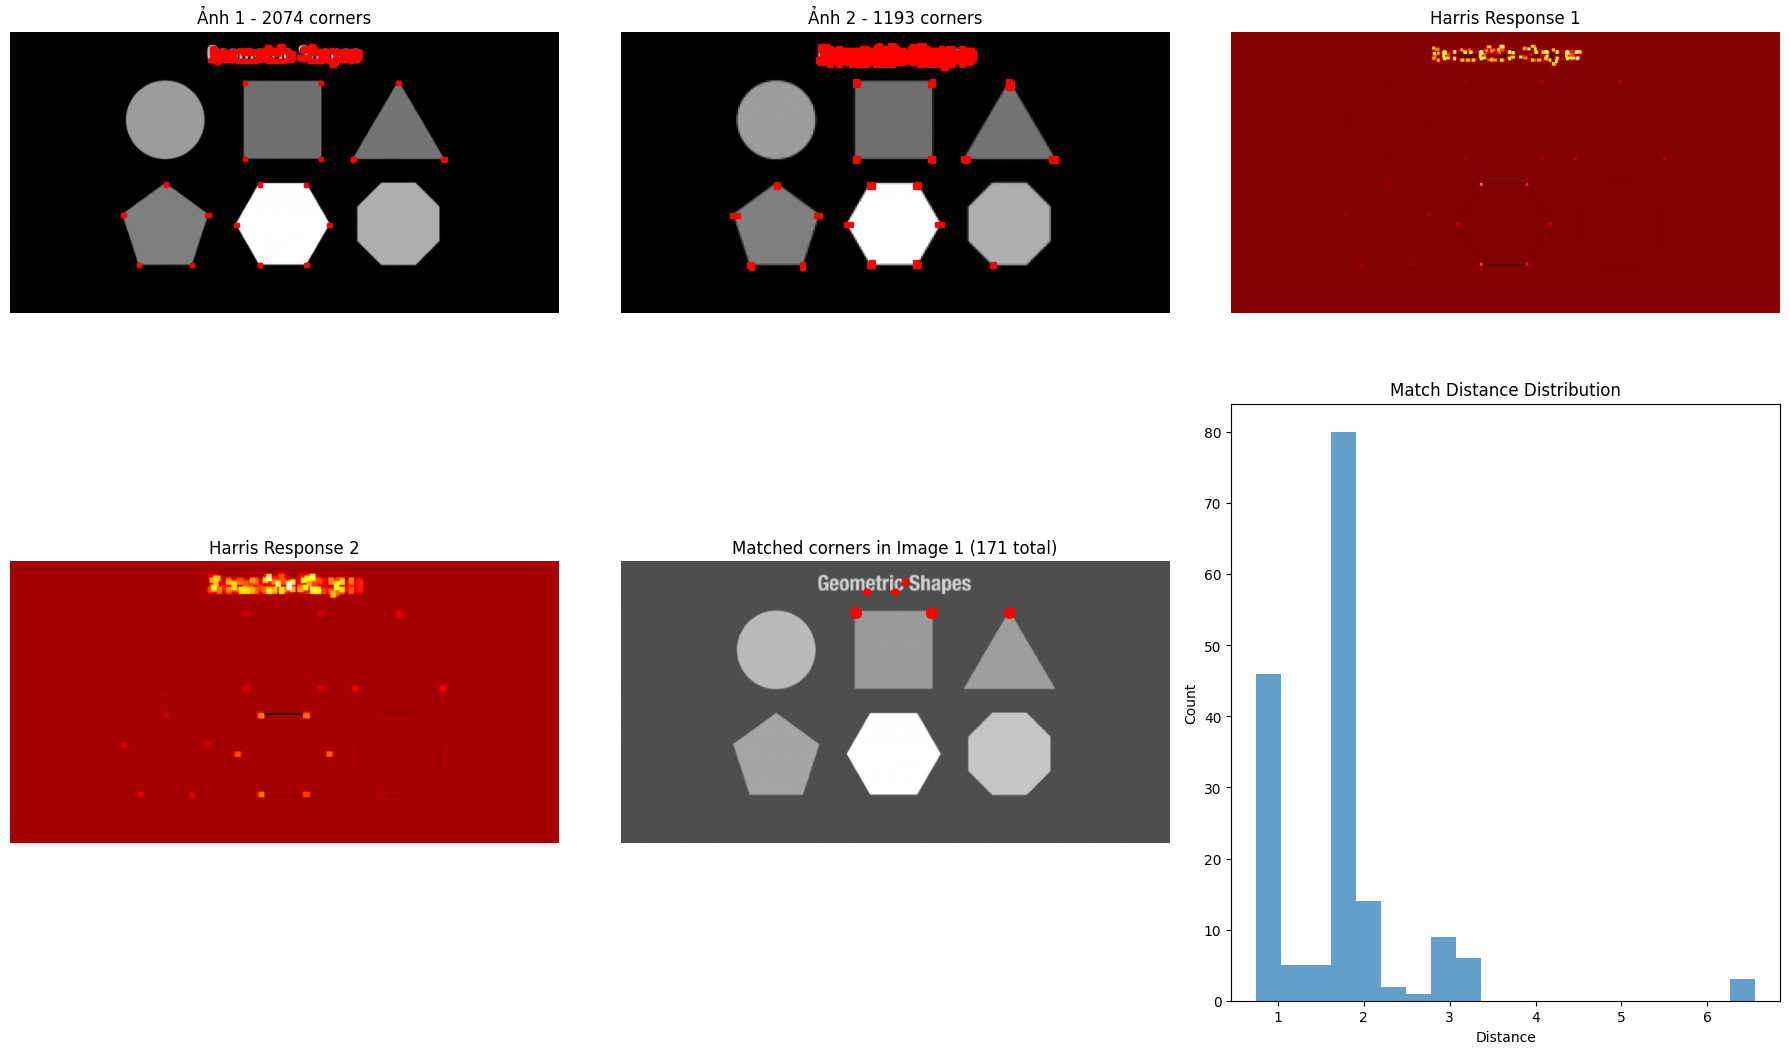


Kết quả:
- Corners ảnh 1: 2074
- Corners ảnh 2: 1193
- Matches: 171
- Tỷ lệ match: 14.3%


In [4]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def extract_harris_corners(img, threshold=0.01):
    gray = np.float32(img)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    dst = cv2.dilate(dst, None)
    coords = np.where(dst > threshold * dst.max())
    corners = list(zip(coords[1], coords[0]))
    return corners, dst

def extract_patch_descriptors(img, corners, patch_size=11):
    descriptors = []
    valid_corners = []
    half_size = patch_size // 2
    
    for x, y in corners:
        if (x >= half_size and x < img.shape[1] - half_size and 
            y >= half_size and y < img.shape[0] - half_size):
            patch = img[y-half_size:y+half_size+1, x-half_size:x+half_size+1]
            patch = patch.astype(np.float32)
            patch = (patch - np.mean(patch)) / (np.std(patch) + 1e-7)
            descriptors.append(patch.flatten())
            valid_corners.append((x, y))
    
    return np.array(descriptors), valid_corners

def match_descriptors(desc1, desc2, threshold=0.8):
    if len(desc1) == 0 or len(desc2) == 0:
        return []
    
    distances = cdist(desc1, desc2, 'euclidean')
    matches = []
    
    for i in range(len(desc1)):
        sorted_indices = np.argsort(distances[i])
        if len(sorted_indices) >= 2:
            best_dist = distances[i][sorted_indices[0]]
            second_best_dist = distances[i][sorted_indices[1]]
            if best_dist / second_best_dist < threshold:
                matches.append((i, sorted_indices[0], best_dist))
    
    return matches

# Đọc ảnh
img1 = Image.open('geometric.png').convert('L')
img1 = np.array(img1)
img2 = cv2.resize(img1, (img1.shape[1]//2, img1.shape[0]//2))  # Resize thay vì rotate

# Tìm Harris corners
corners1, harris1 = extract_harris_corners(img1)
corners2, harris2 = extract_harris_corners(img2)

print(f"Ảnh 1: {len(corners1)} corners")
print(f"Ảnh 2: {len(corners2)} corners")

# Trích xuất descriptors
desc1, valid_corners1 = extract_patch_descriptors(img1, corners1)
desc2, valid_corners2 = extract_patch_descriptors(img2, corners2)

print(f"Descriptors: {len(desc1)} và {len(desc2)}")

# Tìm matches
matches = match_descriptors(desc1, desc2)
print(f"Số matches: {len(matches)}")

# Hiển thị kết quả
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ảnh với corners
axes[0,0].imshow(img1, cmap='gray')
axes[0,0].plot([p[0] for p in valid_corners1], [p[1] for p in valid_corners1], 'r.', markersize=3)
axes[0,0].set_title(f'Ảnh 1 - {len(valid_corners1)} corners')
axes[0,0].axis('off')

axes[0,1].imshow(img2, cmap='gray')
axes[0,1].plot([p[0] for p in valid_corners2], [p[1] for p in valid_corners2], 'r.', markersize=3)
axes[0,1].set_title(f'Ảnh 2 - {len(valid_corners2)} corners')
axes[0,1].axis('off')

# Harris response
axes[0,2].imshow(harris1, cmap='hot')
axes[0,2].set_title('Harris Response 1')
axes[0,2].axis('off')

axes[1,0].imshow(harris2, cmap='hot')
axes[1,0].set_title('Harris Response 2')
axes[1,0].axis('off')

# Matches visualization - hiển thị riêng biệt
if len(matches) > 0:
    axes[1,1].imshow(img1, cmap='gray', alpha=0.7)
    for i, (idx1, idx2, dist) in enumerate(matches[:50]):
        x1, y1 = valid_corners1[idx1]
        axes[1,1].plot(x1, y1, 'ro', markersize=5)
    axes[1,1].set_title(f'Matched corners in Image 1 ({len(matches)} total)')
    axes[1,1].axis('off')
    
    # Thống kê
    distances = [m[2] for m in matches]
    axes[1,2].hist(distances, bins=20, alpha=0.7)
    axes[1,2].set_title('Match Distance Distribution')
    axes[1,2].set_xlabel('Distance')
    axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"\nKết quả:")
print(f"- Corners ảnh 1: {len(valid_corners1)}")
print(f"- Corners ảnh 2: {len(valid_corners2)}")
print(f"- Matches: {len(matches)}")
if len(matches) > 0:
    print(f"- Tỷ lệ match: {len(matches)/min(len(valid_corners1), len(valid_corners2))*100:.1f}%")